In [1]:
#!sudo apt install subversion

In [1]:
import os
import glob
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.random.set_seed(42)

2024-04-20 19:29:18.791840: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-20 19:29:19.087786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 19:29:19.734782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


2024-04-20 19:29:21.107468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-20 19:29:21.228388: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0']


2024-04-20 19:13:34.971006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-20 19:13:34.971065: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
!nvidia-smi

Sat Apr 20 19:01:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 551.61       CUDA Version: 12.4     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8               6W / 200W |      0MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
DATA_DIR = "./lidar"

In [5]:
h5f = h5py.File(os.path.join(DATA_DIR, "v1.h5"),'r') # файл по вашему варианту
X = h5f.get('dataset_X')[:]
Y = h5f.get('dataset_Y').asstr()[:]
h5f.close()

In [6]:
NUM_POINTS = 4096
BATCH_SIZE = 64

# Укажите классы по варианту из вашего файла
CLASSES = {
    0:'Рябина', 
    1:'Ель', 
    2:'Сосна', 
    3:'Дуб',
    4:'Береза'
}

In [7]:
Y = np.array([list(CLASSES.values()).index(y) for y in Y])
indexes = []
[indexes.append(y) for y in list(Y) if y not in indexes]
indexes.sort()
CLASS_MAP = {i: CLASSES[k] for (k, i) in (zip(indexes, range(len(indexes))))}

#кол-во классов по вашему варианту
NUM_CLASSES = len(CLASS_MAP)

for (k, i) in (zip(indexes, range(len(indexes)))):
  Y[Y == k] = i

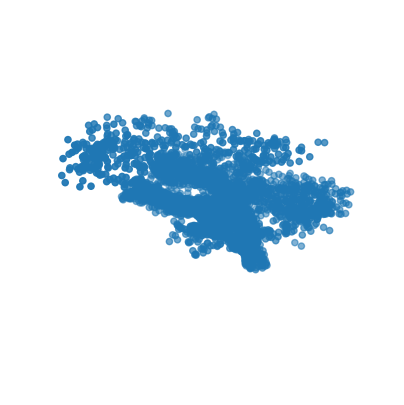

In [8]:
points = X[50]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

/tmp/ipykernel_1419/1953435532.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  data = {'Кол-во деревьев': list(pd.value_counts(Y).sort_index()),


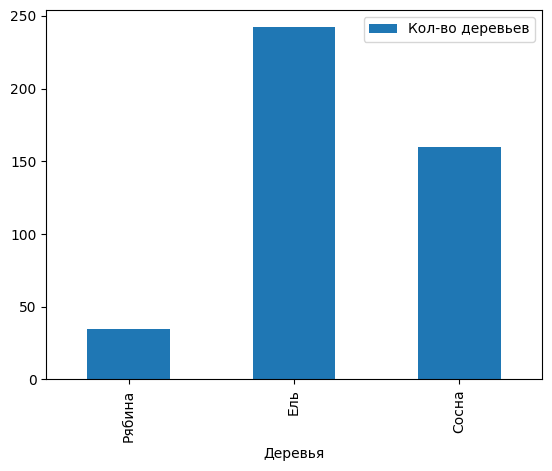

In [9]:
data = {'Кол-во деревьев': list(pd.value_counts(Y).sort_index()),
        'Деревья': list(CLASS_MAP.values())}
df = pd.DataFrame(data).set_index('Деревья')
ax = df.plot.bar()

In [10]:
skf = StratifiedKFold(n_splits=5).split(X, Y)

for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

X_augment = []
y_augment = []

for i in range(4):
    point_select = []
    for x in X_train:
        idx = np.random.choice(X_train.shape[0], size=NUM_POINTS, replace=True)
        point_select.append(x[idx])
    point_select = np.array(point_select)        
    point_select = point_select + np.random.normal(0, 0.005, point_select.shape)
    X_augment.append(point_select)
    y_augment.append(y_train)

X_augment = np.array(X_augment)
y_augment = np.array(y_augment)
X_augment = np.reshape(X_augment,(X_augment.shape[0] * X_augment.shape[1], NUM_POINTS, 3))
y_augment = np.reshape(y_augment,(-1))

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_augment, y_augment))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_augment)).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE)

2024-04-20 19:01:25.439480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [13]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [14]:
def tnet(inputs, num_features):

    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [15]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4096, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 4096, 32)     0           ['batch_normalization[0][0

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
22/22 [==============================] - 47s 2s/step - loss: 5.0708 - sparse_categorical_accuracy: 0.4193 - val_loss: 3.6974 - val_sparse_categorical_accuracy: 0.6552
Epoch 2/10
22/22 [==============================] - 44s 2s/step - loss: 4.1302 - sparse_categorical_accuracy: 0.6464 - val_loss: 3.3333 - val_sparse_categorical_accuracy: 0.6207
Epoch 3/10
22/22 [==============================] - 43s 2s/step - loss: 3.6663 - sparse_categorical_accuracy: 0.7107 - val_loss: 3.2441 - val_sparse_categorical_accuracy: 0.6897
Epoch 4/10
22/22 [==============================] - 44s 2s/step - loss: 3.3233 - sparse_categorical_accuracy: 0.7886 - val_loss: 2.8392 - val_sparse_categorical_accuracy: 0.7586
Epoch 5/10
22/22 [==============================] - 44s 2s/step - loss: 3.0893 - sparse_categorical_accuracy: 0.8457 - val_loss: 2.8675 - val_sparse_categorical_accuracy: 0.6782
Epoch 6/10
 1/22 [>.............................] - ETA: 41s - loss: 2.9658 - sparse_categorical_accuracy: 0.9

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

fig = plt.figure(figsize=(15, 15))
for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
data = test_dataset.take(1)
points, labels = list(data)[0]
points = points[:, ...]
labels = labels[:, ...]

preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

cm = confusion_matrix(y_true=labels, y_pred=preds)

In [ ]:
plot_confusion_matrix(cm=cm, classes=CLASS_MAP.values(), title='Confusion Matrix')